In [66]:
# https://docs.google.com/spreadsheets/d/1dl3KR9u5ddg815b5y0BHdwpmrEPJJbAyjFsBlUFY-Ug/edit#gid=0

import os 
from scipy.io import loadmat
from scipy.signal import medfilt, savgol_filter, detrend
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from timedenoiser.models.tv1d import denoising_1D_TV
from timedenoiser.models.mctv1d import denoising_1D_MCTV
from timedenoiser.models.metv1d import denoising_1D_METV
from timedenoiser.models import parameter as pa

import pywt

import numpy as np 
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def snr(noisy, stats):
    snrs = []
    for stat in stats:
        a = noisy[int(stat[0]): int(stat[1])]
        mx = np.amax(a)
        a = np.divide(a,mx)
        a = np.square(a)
        a = np.asanyarray(a)
        m = a.mean()
        sd = a.std()
        snrs.append(np.where(sd == 0, 0, m/sd))
        
    return np.mean(snrs)

def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal[: -1]


In [17]:
def get_osc(path): 
    speed_dyns = []
    torque_dyns = []
    
    speed_r = csv.reader(open(path.replace('.mat', '_speed.csv'), 'r'), delimiter='\t')
    for row in speed_r:
        if 'Dyn' not in row[2]:
            speed_dyns.append([int(row[0]), int(row[1]), row[2]])
        
    torque_r = csv.reader(open(path.replace('.mat', '_torque.csv'), 'r'), delimiter='\t')
    for row in torque_r:
        if 'Dyn' not in row[2]:
            torque_dyns.append([int(row[0]), int(row[1]), row[2]])
    
    return speed_dyns, torque_dyns

In [71]:
mat_file = '../../../datasets/Data_27012021_noisy/real/OFVC4kW_NoLM_paliers_0to100Hz_Data.mat'
data = loadmat(mat_file)
_, torque_dyns = get_osc(mat_file)
st = torque_dyns[0][0] 
et = torque_dyns[0][1] -500 

noisy = data['noisy_torque'][0]
gt = data['torque'][0]
time = data['time'][0]

# plt.plot(noisy[st:et], alpha=0.5)
# clean_dwt = lowpassfilter(noisy, 0.1)
# # plt.plot(clean_dwt[st:et])
# # plt.plot(gt[st:et])

# clean_dwt2 = denoise_wavelet(noisy, sigma=0.2)
# # plt.plot(clean_dwt2[st:et])

# lamda = np.sqrt(0.2 * noisy.shape[0]) / 5
# K = 100
# err = 0.001
# alpha = 0.3 / lamda
# para = pa.Parameter(lamda, K, err, alpha)

# clean_tv = denoising_1D_TV(noisy, lamda / 2)
# clean_metv = denoising_1D_METV(noisy, para)
# clean_mctv = denoising_1D_MCTV(noisy, para)
    


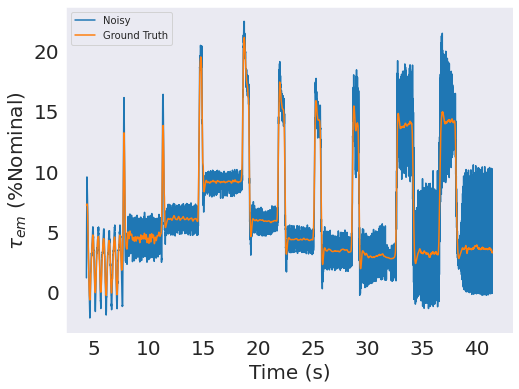

In [72]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(time, noisy, label='Noisy')
plt.plot(time, gt, label='Ground Truth')
plt.legend()
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


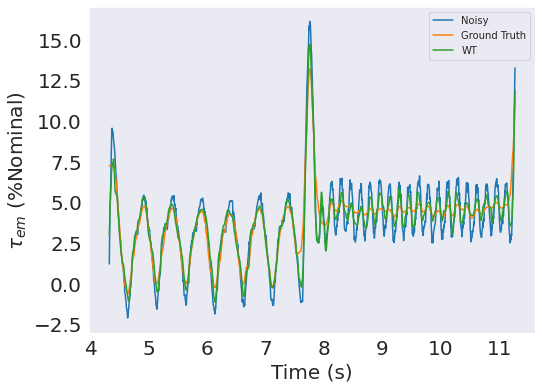

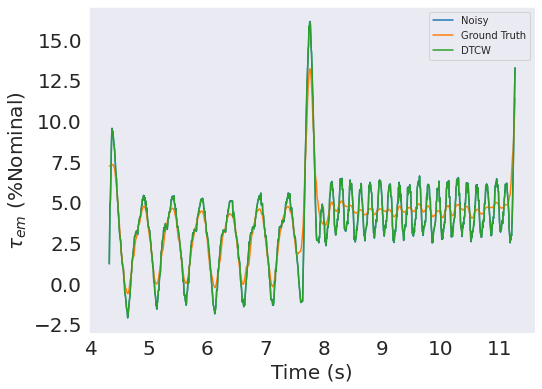

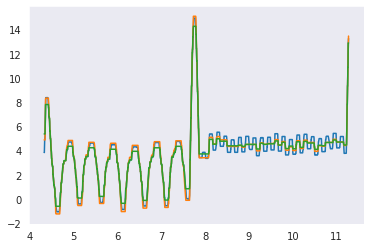

In [73]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(time[0:et], noisy[0:et], label='Noisy')
plt.plot(time[0:et], gt[0:et], label='Ground Truth')
plt.plot(time[0:et], clean_dwt[0:et], label='WT')
plt.legend()
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('wt_res.pdf', bbox_inches="tight", dpi=300)
plt.show()

sns.set_style("dark")
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(time[0:et], noisy[0:et], label='Noisy')
plt.plot(time[0:et], gt[0:et], label='Ground Truth')
plt.plot(time[0:et], clean_dwt2[0:et], label='DTCW')
plt.legend()
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel(r'$\tau_{em}$ (%Nominal)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('dwt2_res.pdf', bbox_inches="tight", dpi=300)
plt.show()

plt.plot(time[0:et], clean_tv[0:et])
plt.plot(time[0:et], clean_metv[0:et])
plt.plot(time[0:et], clean_mctv[0:et])

In [401]:
initial_value_guess = noisy[100]
observation_covariance = np.diag([0.2, 0]) ** 2
transition_covariance = np.diag([0.2, 0]) ** 2
transition_matrix = np.asarray([[1, 0.004],[0, 1]])
kf = KalmanFilter(transition_matrices = transition_matrix,
                  transition_covariance = transition_covariance)
clean_kf, state_cov = kf.smooth(noisy)


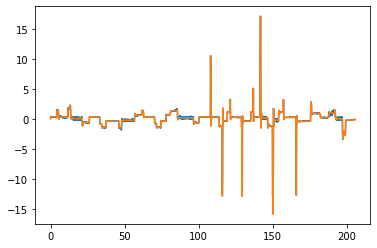

0.14396212730968186


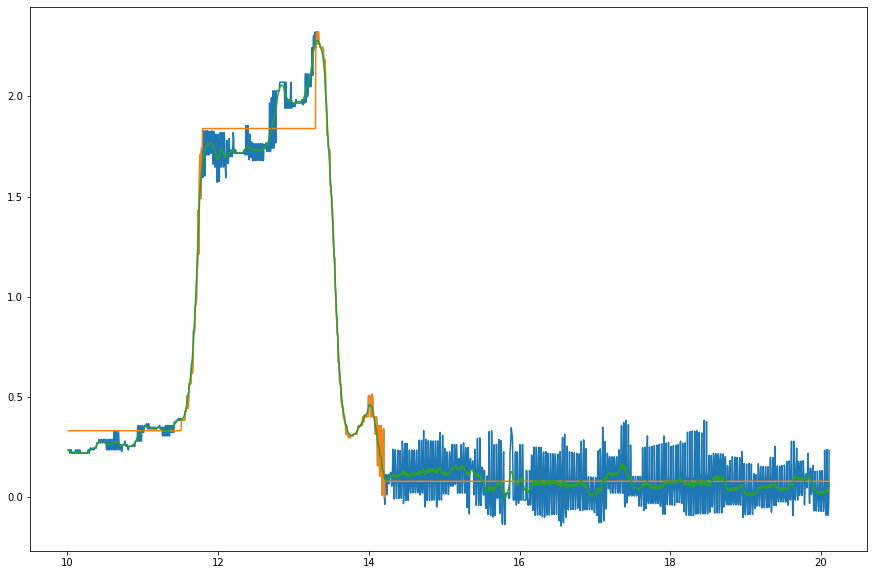

In [402]:
st = int(10 / 0.004)
et = int(20 / 0.004)


plt.plot(time, noisy)
plt.plot(time, gt)
plt.show()
fig = plt.figure(figsize=(15, 10))
plt.plot(time[st:et], noisy[st:et])
plt.plot(time[st:et], gt[st:et])
plt.plot(time[st:et], clean_kf[st:et, 0])
print (rmse(clean_kf[:, 0], gt))

In [526]:
def ResampleLinear1D(original, targetLen):
    original = np.array(original, dtype=np.float)
    index_arr = np.linspace(0, len(original)-1, num=targetLen, dtype=np.float)
    index_floor = np.array(index_arr, dtype=np.int) #Round down
    index_ceil = index_floor + 1
    index_rem = index_arr - index_floor #Remain

    val1 = original[index_floor]
    val2 = original[index_ceil % len(original)]
    interp = val1 * (1.0-index_rem) + val2 * index_rem
    assert(len(interp) == targetLen)
    return interp

def smooth_part(x,window_len,window):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise (ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise (ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise (ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def smooth(x, time, thr=5, w=11, w_t='hanning'):
    steps = [0]
    for i in range(x.shape[0]-1):
        if abs(x[i] - x[i+1]) > 5:
            steps.append(i)
            steps.append(i+1)
    steps.append(len(x)-1)

    steps_n = []
    for i in range(0,len(steps), 2):
        if (steps[i+1] - steps[i]) > w:
            steps_n.append(steps[i])
            steps_n.append(steps[i+1])

    denoised_x = []
    x_n = []
    time_n = []
    for i in range(0, len(steps_n), 2):
        denoised_part = smooth_part(x[steps_n[i]: steps_n[i+1]], window_len=w, window=w_t)[w//2:-1 * w//2 + 1]
        denoised_x += list(denoised_part)
        x_n += list(x[steps_n[i]: steps_n[i+1]])
        time_n += list(time[steps_n[i]: steps_n[i+1]])
        
    denoised_x = ResampleLinear1D(np.asarray(denoised_x), time.shape[0])

    return denoised_x

def clean_signal(time, noisy, sigma, window=251):
    clean_vmf = medfilt(noisy, kernel_size=window)
    clean_sf = savgol_filter(noisy, window_length=window, polyorder=0)
    clean_lowess = lowess(noisy, time, frac=0.05)

    initial_value_guess = noisy[100]
    observation_covariance = np.diag([0.2, 0]) ** 2
    transition_covariance = np.diag([0.2, 0]) ** 2
    transition_matrix = np.asarray([[1, 0.004],[0, 1]])
    kf = KalmanFilter(transition_matrices = transition_matrix,
                      transition_covariance = transition_covariance)
    clean_kf, state_cov = kf.smooth(noisy)

    clean_wt = denoise_wavelet(noisy, sigma=sigma)


    lamda = np.sqrt(sigma * noisy.shape[0]) / 5
    K = 100
    err = 0.001
    alpha = 0.3 / lamda
    para = pa.Parameter(lamda, K, err, alpha)

    clean_tv = denoising_1D_TV(noisy, lamda / 2)
    clean_metv = denoising_1D_METV(noisy, para)
    clean_mctv = denoising_1D_MCTV(noisy, para)
    clean_ad = smooth(noisy, time, w=window-100, w_t="hamming")
    clean_mad = smooth(noisy, time, w=window+100, w_t="hamming")

    return clean_vmf, clean_sf, clean_lowess, clean_kf, \
           clean_wt, clean_tv, clean_metv, clean_mctv, \
            clean_ad, clean_mad

In [527]:
clean_vmf, clean_sf, clean_lowess, clean_kf, \
    clean_wt, clean_tv, clean_metv, clean_mctv, \
    clean_ad, clean_mad = clean_signal(time, noisy, sigma=0.2)

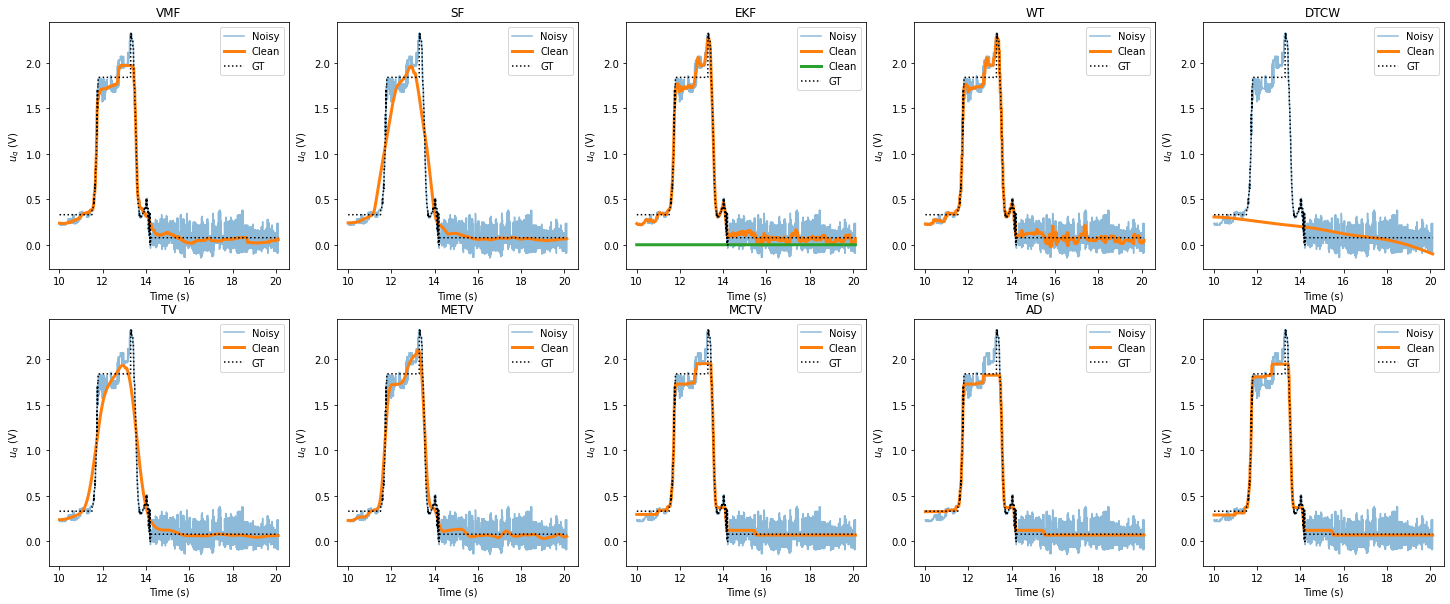

In [405]:


fig = plt.figure(figsize=(25, 10))
plt.subplot(2, 5, 1)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_vmf[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('VMF')

plt.subplot(2, 5, 2)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_sf[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('SF')

plt.subplot(2, 5, 3)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_kf[st: et, 0], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('EKF')

plt.subplot(2, 5, 4)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_wt[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('WT')

plt.subplot(2, 5, 5)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_lowess[st:et, 1], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('DTCW')

plt.subplot(2, 5, 6)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_mad[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('TV')

plt.subplot(2, 5, 7)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_ad[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('METV')

plt.subplot(2, 5, 8)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_tv[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('MCTV')

plt.subplot(2, 5, 9)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_mctv[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('AD')

plt.subplot(2, 5, 10)
plt.plot(time[st: et], noisy[st: et], label="Noisy", alpha=0.5)
plt.plot(time[st: et], clean_metv[st: et], label="Clean", linewidth=3)
plt.plot(time[st: et], gt[st: et], ':k', label="GT")
plt.xlabel('Time (s)')
plt.ylabel(lbl)
plt.legend()
plt.title('MAD')

plt.savefig(fname, bbox_inches="tight", dpi=300, transparent=True)

In [406]:
def rmse(X, Y):
    return np.sqrt(np.mean((X - Y) ** 2))

In [407]:
data1 = loadmat('../../../datasets/Data_27012021_noisy/train_real/OFVC4kW_LM20Hz_TorqueSteps_20190419_Data.mat')
data2 = loadmat('../../../datasets/Data_27012021_noisy/train_real/OFVC4kW_LM10Hz_paliers_0to120PercTnom_Data.mat')
data3 = loadmat('../../../datasets/Data_27012021_noisy/train_real/OFVC4kW_NoLM_SpeedVariations_20190419_Data.mat')

In [409]:
quant = 'voltage_d'
lbl = r'$u_q$ (V)'
fname = quant + '_tqsteps.pdf'
data = data3

noisy = data['noisy_' + quant][0]
time = data['time'][0]

st = int(10 / 0.004)
et = int(20 / 0.004)

gt = noisy.copy()
for stat in data[quant + '_clean_statics']:
    for x in range(int(stat[0]), int(stat[1])):
        gt[x] = np.mean(noisy[int(stat[0]): int(stat[1])])

clean_vmf, clean_sf, clean_lowess, clean_kf, \
    clean_wt, clean_tv, clean_metv, clean_mctv, \
    clean_ad, clean_mad = clean_signal(time, noisy, sigma=0.2)

print ('voltage_d')
print ('vmf :', rmse(clean_vmf, gt))
print ('sf :', rmse(clean_sf, gt))
print ('ekf :', rmse(clean_kf[:, 0], gt))
print ('wt :', rmse(clean_wt, gt))
print ('dtcw :', rmse(clean_lowess[:, 1], gt))
print ('tv :', rmse(clean_ad, gt))
print ('metv :' , rmse(clean_mad, gt))
print ('mctv :', rmse(clean_tv, gt))
print ('ad :', rmse(clean_metv, gt))
print ('mad :', rmse(clean_mctv, gt))

voltage_d
vmf : 6.543526696224103
sf : 6.111786770169309
ekf : 0.8336649923900366
wt : 0.7565721696195298
dtcw : 11.336295066702402
tv : 9.857154175905755
metv : 10.803694896170843
mctv : 0.5525827266692888
ad : 0.5668894814864425
mad : 0.5998763331797947


In [ ]:
quant = 'voltage_q'
lbl = r'$u_q$ (V)'
fname = quant + '_tqsteps.pdf'

noisy = data['noisy_' + quant][0]
time = data['time'][0]

st = int(10 / 0.004)
et = int(20 / 0.004)

gt = noisy.copy()
for stat in data[quant + '_clean_statics']:
    for x in range(int(stat[0]), int(stat[1])):
        gt[x] = np.mean(noisy[int(stat[0]): int(stat[1])])

clean_vmf, clean_sf, clean_lowess, clean_kf, \
    clean_wt, clean_tv, clean_metv, clean_mctv, \
    clean_ad, clean_mad = clean_signal(time, noisy, sigma=0.2)

print (quant)
print ('vmf :', rmse(clean_vmf, gt))
print ('sf :', rmse(clean_sf, gt))
print ('ekf :', rmse(clean_kf[:, 0], gt))
print ('wt :', rmse(clean_wt, gt))
print ('dtcw :', rmse(clean_lowess[:, 1], gt))
print ('tv :', rmse(clean_ad, gt))
print ('metv :' , rmse(clean_mad, gt))
print ('mctv :', rmse(clean_tv, gt))
print ('ad :', rmse(clean_metv, gt))
print ('mad :', rmse(clean_mctv, gt))

In [ ]:
quant = 'current_d'
lbl = r'$u_q$ (V)'
fname = quant + '_tqsteps.pdf'

noisy = data['noisy_' + quant][0]
time = data['time'][0]

st = int(10 / 0.004)
et = int(20 / 0.004)

gt = noisy.copy()
for stat in data[quant + '_clean_statics']:
    for x in range(int(stat[0]), int(stat[1])):
        gt[x] = np.mean(noisy[int(stat[0]): int(stat[1])])

clean_vmf, clean_sf, clean_lowess, clean_kf, \
    clean_wt, clean_tv, clean_metv, clean_mctv, \
    clean_ad, clean_mad = clean_signal(time, noisy, sigma=0.2)

print (quant)
print ('vmf :', rmse(clean_vmf, gt))
print ('sf :', rmse(clean_sf, gt))
print ('ekf :', rmse(clean_kf[:, 0], gt))
print ('wt :', rmse(clean_wt, gt))
print ('dtcw :', rmse(clean_lowess[:, 1], gt))
print ('tv :', rmse(clean_ad, gt))
print ('metv :' , rmse(clean_mad, gt))
print ('mctv :', rmse(clean_tv, gt))
print ('ad :', rmse(clean_metv, gt))
print ('mad :', rmse(clean_mctv, gt))

In [ ]:
quant = 'current_q'
lbl = r'$u_q$ (V)'
fname = quant + '_tqsteps.pdf'

noisy = data['noisy_' + quant][0]
time = data['time'][0]

st = int(10 / 0.004)
et = int(20 / 0.004)

gt = noisy.copy()
for stat in data[quant + '_clean_statics']:
    for x in range(int(stat[0]), int(stat[1])):
        gt[x] = np.mean(noisy[int(stat[0]): int(stat[1])])

clean_vmf, clean_sf, clean_lowess, clean_kf, \
    clean_wt, clean_tv, clean_metv, clean_mctv, \
    clean_ad, clean_mad = clean_signal(time, noisy, sigma=0.2)

print (quant)
print ('vmf :', rmse(clean_vmf, gt))
print ('sf :', rmse(clean_sf, gt))
print ('ekf :', rmse(clean_kf[:, 0], gt))
print ('wt :', rmse(clean_wt, gt))
print ('dtcw :', rmse(clean_lowess[:, 1], gt))
print ('tv :', rmse(clean_ad, gt))
print ('metv :' , rmse(clean_mad, gt))
print ('mctv :', rmse(clean_tv, gt))
print ('ad :', rmse(clean_metv, gt))
print ('mad :', rmse(clean_mctv, gt))

In [ ]:
plt.plot(time, noisy)
plt.plot(time, clean_kf)
plt.plot(time, gt)